In [2]:
from datetime import datetime
import gzip
import os
import requests
import shutil
import tarfile
import tempfile
from osgeo import gdal 
import pandas as pd

# define the date range over which to prepare data
dates = pd.date_range(datetime(2024,12,31), datetime(2025,1,31))

# define the local directory in which to work
snodas_dir = "SNODAS"
# ensure the directory exists
if not os.path.exists(snodas_dir):
    os.makedirs(snodas_dir)

# iterate over each date
for date in dates:
    # prepare the SWE file label for this date
    file_label = f"us_ssmv11034tS__T0001TTNATS{date.strftime('%Y')}{date.strftime('%m')}{date.strftime('%d')}05HP001"
    # check if file already exists
    if os.path.isfile(os.path.join(snodas_dir, file_label + ".nc")):
        print("Skipping " + file_label)
        continue
    print("Processing " + file_label)
    # prepare the SNODAS directory label for this date
    dir_label = f"SNODAS_{date.strftime('%Y%m%d')}"
    # request the .tar file from NSIDC
    r = requests.get(
        "https://noaadata.apps.nsidc.org/NOAA/G02158/masked/" + 
        f"{date.strftime('%Y')}/{date.strftime('%m')}_{date.strftime('%b')}/" +
        dir_label + ".tar"
    )
    # create a temporary directory in which to do work
    with tempfile.TemporaryDirectory() as tmp_dir:
        # save the .tar file
        with open(os.path.join(tmp_dir, dir_label + ".tar"), "wb") as tar_file:
            tar_file.write(r.content)
        # open and extract the .tar file
        with tarfile.open(os.path.join(tmp_dir, dir_label + ".tar"), "r") as tar_file:
            tar_file.extractall(tmp_dir)
        # iterate through all extracted files
        for filename in os.listdir(tmp_dir):
            # check if the file matches the SWE file label
            if os.path.isfile(os.path.join(tmp_dir, filename)) and filename == file_label + ".dat.gz":
                # unzip the SWE .gz file
                with gzip.open(os.path.join(tmp_dir, file_label + ".dat.gz"), "rb") as gz_in:
                    with open(os.path.join(tmp_dir, file_label + ".dat"), "wb") as gz_out:
                        shutil.copyfileobj(gz_in, gz_out)
                # write the SWE .hdr file
                with open(os.path.join(tmp_dir, file_label + ".hdr"), "w") as hdr_file:
                    hdr_file.write(
                        "ENVI\n"
                        "samples = 6935\n" +
                        "lines = 3351\n" +
                        "bands = 1\n" +
                        "header offset = 0\n" + 
                        "file type = ENVI Standard\n" + 
                        "data type = 2\n" +
                        "interleave = bsq\n" +
                        "byte order = 1"
                    )
                # run the gdal translator using date-specific bounding box
                command = " ".join([
                    "gdal_translate",
                    "-of NetCDF",
                    "-a_srs EPSG:4326",
                    "-a_nodata -9999",
                    "-a_ullr -124.73375000000000 52.87458333333333 -66.94208333333333 24.94958333333333" 
                    if date < datetime(2013, 10, 1)
                    else "-a_ullr -124.73333333333333 52.87500000000000 -66.94166666666667 24.95000000000000",
                    os.path.join(tmp_dir, file_label + ".dat"),
                    os.path.join(snodas_dir, file_label + ".nc")
                ])
                if os.system(command) > 0: 
                    print(f"Error processing command `{command}`")

Skipping us_ssmv11034tS__T0001TTNATS2024123105HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010105HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010205HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010305HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010405HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010505HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010605HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010705HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010805HP001
Skipping us_ssmv11034tS__T0001TTNATS2025010905HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011005HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011105HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011205HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011305HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011405HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011505HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011605HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011705HP001
Skipping us_ssmv11034tS__T0001TTNATS2025011805HP001
Skipping us_

In [3]:
import rioxarray as rxr
import xarray as xr
from datetime import datetime
import pandas as pd
import os

dates = pd.date_range(datetime(2024,12,31), datetime(2025,1,31))
print("Writing snodas-merged.nc")
ds = xr.combine_by_coords(
    [
        rxr.open_rasterio(
            os.path.join(
                snodas_dir, 
                f"us_ssmv11034tS__T0001TTNATS{date.strftime('%Y')}{date.strftime('%m')}{date.strftime('%d')}05HP001.nc"
            )
        ).drop_vars("band").assign_coords(time=date).expand_dims(dim="time")
        for date in dates
    ], 
    combine_attrs="drop_conflicts"
).to_netcdf(os.path.join(snodas_dir, "snodas-merged.nc"))

Writing snodas-merged.nc


In [ ]:
import xarray as xr
import os
import rioxarray
from affine import Affine


# Load original SNODAS dataset
input_path = os.path.join("SNODAS", "snodas-merged.nc")
ds = xr.open_dataset(input_path)
da = ds["Band1"]

# Trim to dimensions divisible by coarsening factor
factor_y = 20
factor_x = 20
ny = (da.sizes['y'] // factor_y) * factor_y
nx = (da.sizes['x'] // factor_x) * factor_x
da = da.isel(y=slice(0, ny), x=slice(0, nx))

# Attach spatial metadata BEFORE coarsening
da = da.rio.write_crs("EPSG:4326")
da = da.rio.set_spatial_dims(x_dim="x", y_dim="y")

# Save the original transform before coarsening
original_transform = da.rio.transform()
res_y = original_transform[4] * factor_y  
res_x = original_transform[0] * factor_x  

# Coarsen with nan-safe mean
coarsened_da = da.coarsen(y=factor_y, x=factor_x, boundary='trim').mean(skipna=True)

# Recalculate new transform and set it
new_transform = Affine(
    res_x, 0.0, original_transform[2],
    0.0, res_y, original_transform[5]
)

coarsened_da.rio.write_transform(new_transform, inplace=True)
coarsened_da.rio.write_crs("EPSG:4326", inplace=True)
coarsened_da.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

# Save corrected 20km version
output_path = os.path.join("SNODAS", "snodas-merged_20km.nc")
coarsened_da.to_netcdf(output_path)
print(f"Saved fixed 20km SNODAS dataset: {output_path}")


Saved fixed 20km SNODAS dataset: SNODAS/snodas-merged_20km.nc


In [ ]:
import xarray as xr

ds = xr.open_dataset("SNODAS/snodas-merged_20km.nc")
da = ds["Band1"]  # any data variable with spatial dims set

minx, miny, maxx, maxy = da.rio.bounds()  # (lon_min, lat_min, lon_max, lat_max)
print(f"lon: [{minx}, {maxx}]")
print(f"lat: [{miny}, {maxy}]")


lon: [-124.73333333333335, -67.06666666666669]
lat: [25.041666666666664, 52.875]


In [ ]:
# import rioxarray as xr
# from datetime import timedelta, timezone
# from shapely.geometry import box
# import geopandas as gpd
# import os
# import matplotlib.pyplot as plt
# from shapely import Polygon

# # access us states shapefile for plotting context

# # us_map = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")
# # select contiguous states and transform to WGS84 coordinates
# # conus = us_map[~us_map.STUSPS.isin(["AK", "HI", "PR"])].to_crs("EPSG:4326")

# # define the watershed boundary number
# wbd = 10
# # check if the watershed boundary shapefile already exists
# if not all(os.path.isfile(f"WBD_{wbd}_HU2" + ext) for ext in [".shp", ".shx"]):
#     print(f"Downloading/extracting WBD {wbd} shapefile")
#     # request the shapefile from the U.S.G.S. cloud service
#     r = requests.get(
#         f"https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/HU2/Shape/WBD_{wbd}_HU2_Shape.zip"
#     )
#     # create a temporary directory in which to do work
#     with tempfile.TemporaryDirectory() as tmp_dir:
#         # save the .zip file
#         with open(os.path.join(tmp_dir, f"WBD_{wbd}_HU2_Shape.zip"), "wb") as zip_file:
#             zip_file.write(r.content)
#         # extract the directory
#         with zipfile.ZipFile(os.path.join(tmp_dir, f"WBD_{wbd}_HU2_Shape.zip"), 'r') as zip_file:
#             zip_file.extractall(os.path.join(tmp_dir, f"WBD_{wbd}_HU2_Shape"))
#         # move the HU2 shapefile to the root
#         for ext in [".shp", ".shx"]:
#             os.replace(os.path.join(tmp_dir, f"WBD_{wbd}_HU2_Shape", "Shape", "WBDHU2" + ext), f"WBD_{wbd}_HU2" + ext)

# # load the watershed boundary shapefile as a geodataframe
# mo_basin = gpd.read_file(f"WBD_10_HU2.shp")
# # construct a geoseries with the exterior of the basin and WGS84 coordinates
# mo_basin = gpd.GeoSeries(Polygon(mo_basin.iloc[0].geometry.exterior), crs="EPSG:4326")



In [9]:
import os
from pyhdf.SD import SD, SDC
import xarray as xr
import numpy as np
import pandas as pd
import earthaccess
# import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
from shapely.geometry import box

domain = box(-114, 37, -90, 50)
minx, miny, maxx, maxy = domain.bounds

def convert_to_xarray(hdf_file, dataset_name):
    if dataset_name not in hdf_file.datasets():
        raise ValueError(f"{dataset_name} not found in file.")
    data = hdf_file.select(dataset_name)
    arr = data[:]
    attrs = data.attributes()
    dims = [dim_name for dim_name, _ in data.dimensions().items()]
    fill_value = attrs.get('_FillValue', None)
    arr = np.where(arr == fill_value, np.nan, arr) if fill_value is not None else arr
    return xr.DataArray(arr, name=dataset_name, dims=dims, attrs=attrs)


def create_basin_mask(lat, lon, basin_geometry):
    flat_points = np.column_stack([lon.ravel(), lat.ravel()])
    mask_flat = np.array([basin_geometry.contains(Point(pt)) for pt in flat_points])
    return mask_flat.reshape(lat.shape)



def download_latest_datasets(collection, start_date, end_date):
    earthaccess.login(strategy="netrc")
    results = earthaccess.search_data(short_name=collection, temporal=(start_date, end_date))
    return earthaccess.download(results, local_path=os.getcwd())

# config
collection = "AIRS3STD"
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 1, 31)

raw_dir = "daily_airtemp"
masked_dir = "daily_airtemp_masked"
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(masked_dir, exist_ok=True)

file_paths = download_latest_datasets(collection, start_date, end_date)
file_paths = [f for f in file_paths if "v7.0.7.0" in os.path.basename(f)]
dates = pd.date_range(start=start_date, periods=len(file_paths), freq="D")


for i, file_path in enumerate(file_paths):
    if not os.path.exists(file_path):
        print(f" Missing file: {file_path}")
        continue

    try:
        hdf = SD(file_path, SDC.READ)
        temp = convert_to_xarray(hdf, 'SurfAirTemp_D')
        lat = hdf.select('Latitude')[:]
        lon = hdf.select('Longitude')[:]
    except Exception as e:
        print(f"Skipping {file_path} — error: {e}")
        continue

    da = temp.expand_dims(time=[dates[i]])
    ds = xr.Dataset({"SurfAirTemp_D": da}).assign_coords({
        'lat': (('YDim:descending', 'XDim:descending'), lat),
        'lon': (('YDim:descending', 'XDim:descending'), lon)
    })

    # ds['SurfAirTemp_D'] = bilinear_interpolation(ds['SurfAirTemp_D'])

    mask = create_basin_mask(ds['lat'].values, ds['lon'].values, domain)
    mask_da = xr.DataArray(
        mask,
        coords={"YDim:descending": ds['lat']['YDim:descending'],
                "XDim:descending": ds['lon']['XDim:descending']},
        dims=["YDim:descending", "XDim:descending"]
    )
    masked_ds = ds.where(mask_da, drop=True)

    date_str = dates[i].strftime("%Y%m%d")
    raw_path = os.path.join(raw_dir, f"AIRS_SurfAirTemp_D_{date_str}.nc")
    masked_path = os.path.join(masked_dir, f"AIRS_SurfAirTemp_D_masked_{date_str}.nc")

    ds.to_netcdf(raw_path)
    masked_ds.to_netcdf(masked_path)
    print(f"Saved: {raw_path}")
    print(f"Saved: {masked_path}")
    
    from pyhdf.SD import SD, SDC

    # example_file = file_paths[0]
    # hdf = SD(example_file, SDC.READ)

    # # Print available dataset names
    # print("Available datasets:")
    # for name in hdf.datasets().keys():
    #     print(" -", name)


# # cleanup
# for f in file_paths:
#     try:
#         os.remove(f)
#     except Exception as e:
#         print(f"[!] Could not delete {f}: {e}")


/opt/anaconda3/envs/tatc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
QUEUEING TASKS | : 100%|██████████| 64/64 [00:00<00:00, 8193.50it/s]
PROCESSING TASKS | : 100%|██████████| 64/64 [07:11<00:00,  6.74s/it]
COLLECTING RESULTS | : 100%|██████████| 64/64 [00:00<00:00, 335125.41it/s]


Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250101.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250101.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250102.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250102.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250103.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250103.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250104.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250104.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250105.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250105.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250106.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250106.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250107.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250107.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250108.nc
Saved: daily_airtemp_masked/AIRS_SurfAirTemp_D_masked_20250108.nc
Saved: daily_airtemp/AIRS_SurfAirTemp_D_20250109.nc
Save

In [ ]:
import os
import xarray as xr
import rioxarray
from rasterio.enums import Resampling

# CONFIGURATION

in_dir = "daily_airtemp_masked"
out_dir = "daily_airtemp_20km"
os.makedirs(out_dir, exist_ok=True)

# Load 20km reference grid from eta2 file
ds_20km = xr.open_dataset("SNODAS/snodas-merged_20km.nc")
# print(f"  Original shape: {ds_20km['Band1'].shape}")

ref_grid = ds_20km["Band1"].rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="x", y_dim="y")


def reproject_to_20km(da, reference):
    # Drop lat/lon coords if they exist to avoid projection errors
    for coord in ["lat", "lon"]:
        if coord in da.coords:
            da = da.drop_vars(coord)

    # Confirm required dimensions
    if "x" not in da.dims or "y" not in da.dims:
        raise ValueError("Input DataArray must have 'x' and 'y' dimensions")

    # Assign CRS and spatial dimensions
    da = da.rio.write_crs("EPSG:4326")
    da = da.rio.set_spatial_dims(x_dim="x", y_dim="y")

    # Reproject to match 20km grid
    da_20km = da.rio.reproject_match(reference, resampling=Resampling.bilinear)

    return da_20km

# MAIN LOOP

for file in sorted(os.listdir(in_dir)):
    if not file.endswith(".nc"):
        continue

    in_path = os.path.join(in_dir, file)
    out_path = os.path.join(out_dir, file)

    # Load dataset and extract eta0
    ds = xr.open_dataset(in_path)
    da = ds["SurfAirTemp_D"]
    dims = list(da.dims)
    ydim = next(d for d in dims if d.lower().startswith("y"))
    xdim = next(d for d in dims if d.lower().startswith("x"))
    da = da.rename({ydim: "y", xdim: "x"})

    lat = ds["lat"][:, 0].rename({"YDim:descending": "y"}) if "YDim:descending" in ds["lat"].dims else ds["lat"][:, 0]
    lon = ds["lon"][0, :].rename({"XDim:descending": "x"}) if "XDim:descending" in ds["lon"].dims else ds["lon"][0, :]
    da = da.assign_coords(y=lat, x=lon)
        # Print original shape before reprojection
    # print(f"\n{file}")
    # print(f"  Original shape: {da.shape}")

    try:
        
        # Reproject to 20km grid
        da_20km = reproject_to_20km(da, ref_grid)
        # print(f"  Reprojected shape: {da_20km.shape}")
        # Prepare output
        ds_out = da_20km.to_dataset(name="SurfAirTemp_D")
        ds_out["SurfAirTemp_D"].attrs.pop("grid_mapping", None)
        ds_out.attrs.pop("grid_mapping", None)

        # Save
        ds_out.to_netcdf(out_path)
        print(f"Saved: {out_path}")

    except Exception as e:
        print(f"Failed: {file} — {e}")



Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250101.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250102.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250103.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250104.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250105.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250106.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250107.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250108.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250109.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250110.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250111.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250112.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250113.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250114.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTemp_D_masked_20250115.nc
Saved: daily_airtemp_20km/AIRS_SurfAirTe

In [ ]:
import xarray as xr
from shapely.geometry import box

# Define rectangular clipping domain
domain = box(-114, 37, -90, 50)
minx, miny, maxx, maxy = domain.bounds

# 1. Snow Cover
ds_sc = xr.open_dataset("efficiency_snow_cover.nc")
# sc_da = ds_sc["Weekly_Snow_Cover"]
# sc_clipped = reproject_and_clip_bbox(sc_da, ds_20km_var, minx, miny, maxx, maxy)
sc_clipped = ds_sc.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
sc_clipped.to_netcdf("efficiency_snow_cover_20km_masked.nc")

# 2. Optical Resolution
ds_res = xr.open_dataset("efficiency_resolution_PMW.nc")
res_da = ds_res["Monthly_Resolution_Abs"]
res_clipped = res_da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
res_clipped.to_netcdf("efficiency_resolution_20km_masked.nc")

# 3. SAR Resolution
ds_res_SAR = xr.open_dataset("efficiency_resolution_SAR.nc")
res_sar_da = ds_res_SAR["Monthly_Resolution_Abs"]
res_sar_clipped = res_sar_da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
res_sar_clipped.to_netcdf("efficiency_resolution_SAR_20km_masked.nc")


In [13]:
import xarray as xr
import numpy as np
import rioxarray
import geopandas as gpd
import os
from datetime import datetime, timedelta

# Load the Missouri River Basin shapefile and ensure it's in EPSG:4326
# mo_basin = gpd.read_file("WBD_10_HU2.shp").to_crs("EPSG:4326")
domain = box(-114, 37, -90, 50)
minx, miny, maxx, maxy = domain.bounds

# Constants for the logistic transformation
T = 150      # SWE threshold
k = 0.03     # Steepness
epsilon = 0.05  # Intercept

# Define the logistic function to compute beta2
def calculate_beta2(swe):
    return epsilon + (1 - epsilon) / (1 + np.exp(k * (swe - T)))

# Base input/output
input_file = "SNODAS/snodas-merged_20km.nc"
output_dir = "sensor_saturation_daily/"
os.makedirs(output_dir, exist_ok=True)

# Loop through Jan 1 to Jan 31
for day_offset in range(31):
    date = datetime(2025, 1, 1) + timedelta(days=day_offset)
    date_str = date.strftime("%Y-%m-%d")
    print(f"Processing {date_str}")

    # Open only the current day's SWE
    with xr.open_dataset(input_file) as ds:
        if not ds.rio.crs:
            ds = ds.rio.write_crs("EPSG:4326")

        # Select the specific time step
        daily_swe = ds["Band1"].sel(time=date)

        # Squeeze 'band' if present
        if "band" in daily_swe.dims and daily_swe.sizes["band"] == 1:
            daily_swe = daily_swe.squeeze("band")

        # Clip to basin
        clipped = daily_swe.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

        # Calculate eta2
        eta2 = calculate_beta2(clipped)
        eta2 = eta2.fillna(1)

        eta2_da = xr.DataArray(
            eta2,
            coords={"y": clipped["y"], "x": clipped["x"]},
            dims=["y", "x"],
            name="eta2"
        )
        eta2_ds = xr.Dataset({"eta2": eta2_da})

        eta2_ds = eta2_ds.expand_dims(time=[date])

        # Remove grid_mapping if present
        for var in eta2_ds.variables:
            eta2_ds[var].attrs.pop("grid_mapping", None)

        # Save to file
        filename = f"{output_dir}/Sensor_Saturation_GCOM_{date_str}.nc"
        eta2_ds.to_netcdf(filename)

    print(f"Saved: {filename}")


Processing 2025-01-01
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-01.nc
Processing 2025-01-02
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-02.nc
Processing 2025-01-03
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-03.nc
Processing 2025-01-04
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-04.nc
Processing 2025-01-05
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-05.nc
Processing 2025-01-06
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-06.nc
Processing 2025-01-07
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-07.nc
Processing 2025-01-08
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-08.nc
Processing 2025-01-09
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-09.nc
Processing 2025-01-10
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-10.nc
Processing 2025-01-11
Saved: sensor_saturation_daily//Sensor_Saturation_GCOM_2025-01-11.nc

In [14]:
import xarray as xr
import numpy as np
import rioxarray
import geopandas as gpd
import os
from datetime import datetime, timedelta

# Load Missouri River Basin shapefile
# mo_basin = gpd.read_file("WBD_10_HU2.shp").to_crs("EPSG:4326")
domain = box(-114, 37, -90, 50)
minx, miny, maxx, maxy = domain.bounds

# Logistic function parameters for Capella
T = 150
k = -0.03  # Capella-specific slope
epsilon = 0.05

# Logistic transformation function
def calculate_eta2(swe):
    return epsilon + (1 - epsilon) / (1 + np.exp(k * (swe - T)))

# File paths
input_file = "SNODAS/snodas-merged_20km.nc"
output_dir = "sensor_saturation_daily/"
os.makedirs(output_dir, exist_ok=True)

# Loop through Jan 1–31, 2025
for day_offset in range(31):
    date = datetime(2025, 1, 1) + timedelta(days=day_offset)
    date_str = date.strftime("%Y-%m-%d")
    print(f"Processing {date_str} for Capella...")

    with xr.open_dataset(input_file) as ds:
        if not ds.rio.crs:
            ds = ds.rio.write_crs("EPSG:4326")

        swe = ds["Band1"].sel(time=date)

        if "band" in swe.dims and swe.sizes["band"] == 1:
            swe = swe.squeeze("band")

        clipped = swe.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

        eta2 = calculate_eta2(clipped)
        eta2 = eta2.fillna(1)

        eta2_da = xr.DataArray(
            eta2,
            coords={"y": clipped["y"], "x": clipped["x"]},
            dims=["y", "x"],
            name="eta2"
        )
        eta2_ds = xr.Dataset({"eta2": eta2_da}).expand_dims(time=[date])

        for var in eta2_ds.variables:
            eta2_ds[var].attrs.pop("grid_mapping", None)

        filename = f"{output_dir}/Sensor_Saturation_Capella_{date_str}.nc"
        eta2_ds.to_netcdf(filename)

    print(f"Saved: {filename}")


Processing 2025-01-01 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-01.nc
Processing 2025-01-02 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-02.nc
Processing 2025-01-03 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-03.nc
Processing 2025-01-04 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-04.nc
Processing 2025-01-05 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-05.nc
Processing 2025-01-06 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-06.nc
Processing 2025-01-07 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-07.nc
Processing 2025-01-08 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-08.nc
Processing 2025-01-09 for Capella...
Saved: sensor_saturation_daily//Sensor_Saturation_Capella_2025-01-09.nc
Processing 2025-01-

In [15]:
import xarray as xr
import numpy as np
import rioxarray
import geopandas as gpd
import os
from datetime import datetime, timedelta
from shapely import box

# Load Missouri River Basin shapefile (assumed EPSG:4326)
# mo_basin = gpd.read_file("WBD_10_HU2.shp").to_crs("EPSG:4326")
domain = box(-114, 37, -90, 50)
minx, miny, maxx, maxy = domain.bounds
# SWE logistic difference transformation parameters
T = 10     # threshold
k = 0.2    # slope

def calculate_eta0(swe_change):
    """Logistic transformation to compute eta0."""
    return 1 / (1 + np.exp(-k * (swe_change - T)))

# Input & output paths
input_file = "SNODAS/snodas-merged_20km.nc"
output_dir = "SWE_Change_daily/"
os.makedirs(output_dir, exist_ok=True)

# Loop from Jan 2 to Jan 31 (because Jan 1 has no prior day for difference)
for i in range(1, 32):
    date_current = datetime(2025, 1, i)
    date_prev = date_current - timedelta(days=1)
    date_str = date_current.strftime("%Y-%m-%d")
    print(f"Processing SWE change for {date_str}")

    # Open only the 2 relevant days
    with xr.open_dataset(input_file) as ds:
        if not ds.rio.crs:
            ds = ds.rio.write_crs("EPSG:4326")

        # Select SWE for the two dates
        swe = ds["Band1"].sel(time=[date_prev, date_current])

        # Remove 'band' if present
        if "band" in swe.dims and swe.sizes["band"] == 1:
            swe = swe.squeeze("band")

        # Clip SWE to the Missouri basin
        swe_clipped = swe.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

        # Compute SWE difference and absolute value (retain 0 changes)
        swe_diff = swe_clipped.diff(dim="time").isel(time=0)
        swe_diff_abs = np.abs(swe_diff)

        # Calculate eta0
        eta0 = calculate_eta0(swe_diff_abs)

        # Fill NaNs (e.g. outside SWE or missing) with eta = 1
        eta0 = eta0.fillna(1)

        # Wrap eta0 in a DataArray
        eta0_da = xr.DataArray(
            eta0,
            coords={"y": swe_diff["y"], "x": swe_diff["x"]},
            dims=["y", "x"],
            name="eta0"
        )
        eta0_ds = xr.Dataset({"eta0": eta0_da}).expand_dims(time=[date_current])

        # Clean metadata
        for var in eta0_ds.variables:
            eta0_ds[var].attrs.pop("grid_mapping", None)

        # Save daily file
        output_path = os.path.join(output_dir, f"SWE_Change_{date_str}.nc")
        eta0_ds.to_netcdf(output_path)
        print(f"Saved: {output_path}")


Processing SWE change for 2025-01-01
Saved: SWE_Change_daily/SWE_Change_2025-01-01.nc
Processing SWE change for 2025-01-02
Saved: SWE_Change_daily/SWE_Change_2025-01-02.nc
Processing SWE change for 2025-01-03
Saved: SWE_Change_daily/SWE_Change_2025-01-03.nc
Processing SWE change for 2025-01-04
Saved: SWE_Change_daily/SWE_Change_2025-01-04.nc
Processing SWE change for 2025-01-05
Saved: SWE_Change_daily/SWE_Change_2025-01-05.nc
Processing SWE change for 2025-01-06
Saved: SWE_Change_daily/SWE_Change_2025-01-06.nc
Processing SWE change for 2025-01-07
Saved: SWE_Change_daily/SWE_Change_2025-01-07.nc
Processing SWE change for 2025-01-08
Saved: SWE_Change_daily/SWE_Change_2025-01-08.nc
Processing SWE change for 2025-01-09
Saved: SWE_Change_daily/SWE_Change_2025-01-09.nc
Processing SWE change for 2025-01-10
Saved: SWE_Change_daily/SWE_Change_2025-01-10.nc
Processing SWE change for 2025-01-11
Saved: SWE_Change_daily/SWE_Change_2025-01-11.nc
Processing SWE change for 2025-01-12
Saved: SWE_Change

In [16]:
import os
import glob
import xarray as xr
import numpy as np
from shapely import box

domain = box(-114, 37, -90, 50)
minx, miny, maxx, maxy = domain.bounds

# Parameters for eta1
T_ref = 0.0  # °C
k     = 0.5
b     = 0.0

# Input / output directories
masked_dir = "daily_airtemp_20km"
out_dir    = "daily_airtemp_eta1"
os.makedirs(out_dir, exist_ok=True)

# Compute eta01 from temperature (K), treating NaN as eta = 1
def compute_eta1(da_kelvin):
    da_C = da_kelvin - 273.15
    eta = 1.0 / (1.0 + np.exp(k * (da_C - T_ref) + b))
    eta_filled = eta.fillna(1.0)  # Replace NaNs with efficiency = 1
    return eta_filled

# Process each temperature file
for path in sorted(glob.glob(os.path.join(masked_dir, "*.nc"))):
    with xr.open_dataset(path) as ds:
        if "SurfAirTemp_D" not in ds.variables:
            print(f"Skipping {path} — no SurfAirTemp_D found.")
            continue

        da = ds["SurfAirTemp_D"]
        eta1 = compute_eta1(da.squeeze())  # remove time dimension
        eta1.name = "eta1"

        eta1.rio.write_crs("EPSG:4326", inplace=True)
        eta1.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
        eta1 = eta1.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

        eta1.attrs.update({
            "long_name":   "Efficiency factor",
            "description": "1 / (1 + exp(k*(T_C - 0))); NaNs replaced with 1",
            "units":       "1 (unitless)"
        })

        ds_out = eta1.to_dataset()

        safe_attrs = {
            k: v for k, v in ds["SurfAirTemp_D"].attrs.items()
            if k != "grid_mapping"
        }
        ds_out["eta1"].attrs.update(safe_attrs)

        ds_out.attrs.update({
            k: v for k, v in ds.attrs.items()
            if k != "grid_mapping"
        })
        

    filename = os.path.basename(path)
    date_str = filename.split("_")[-1].replace(".nc", "")
    out_name = f"temperature_{date_str}.nc"
    out_path = os.path.join(out_dir, out_name)

    ds_out.to_netcdf(out_path)
    print(f" Saved dataset {out_path}")


 Saved dataset daily_airtemp_eta1/temperature_20250101.nc
 Saved dataset daily_airtemp_eta1/temperature_20250102.nc
 Saved dataset daily_airtemp_eta1/temperature_20250103.nc
 Saved dataset daily_airtemp_eta1/temperature_20250104.nc
 Saved dataset daily_airtemp_eta1/temperature_20250105.nc
 Saved dataset daily_airtemp_eta1/temperature_20250106.nc
 Saved dataset daily_airtemp_eta1/temperature_20250107.nc
 Saved dataset daily_airtemp_eta1/temperature_20250108.nc
 Saved dataset daily_airtemp_eta1/temperature_20250109.nc
 Saved dataset daily_airtemp_eta1/temperature_20250110.nc
 Saved dataset daily_airtemp_eta1/temperature_20250111.nc
 Saved dataset daily_airtemp_eta1/temperature_20250112.nc
 Saved dataset daily_airtemp_eta1/temperature_20250113.nc
 Saved dataset daily_airtemp_eta1/temperature_20250114.nc
 Saved dataset daily_airtemp_eta1/temperature_20250115.nc
 Saved dataset daily_airtemp_eta1/temperature_20250116.nc
 Saved dataset daily_airtemp_eta1/temperature_20250117.nc
 Saved dataset

USING x_y for Polygon_id

In [ ]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from bisect import bisect_right

from datetime import datetime, timedelta, timezone
from shapely.geometry import box
from rasterio.features import geometry_mask
from rasterio.enums import Resampling

from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value
from pulp import GUROBI
from joblib import Parallel, delayed

from tatc import utils
from tatc.schemas import PointedInstrument, Satellite, TwoLineElements
from tatc.analysis import collect_ground_track
from tatc.utils import compute_orbit_period
from tatc.schemas import CircularOrbit


# Helper functions 
def load_daily_dataset(base_dir, date, prefix, suffix_date_fmt="%Y-%m-%d", file_ext=".nc"):
    date_str = date.strftime(suffix_date_fmt)
    path = os.path.join(base_dir, f"{prefix}{date_str}{file_ext}")
    return xr.open_dataset(path)

def extract_from_timelayer(ds, date):
    return ds.sel(time=date)

        # Assign polygon_id deterministically from (x, y)
def make_polygon_id(df: pd.DataFrame, decimals: int = 5) -> pd.Series:
    x_rounded = np.round(df["x"].to_numpy(), decimals)
    y_rounded = np.round(df["y"].to_numpy(), decimals)
    return pd.Series(
        [f"{x_rounded[i]:.{decimals}f}_{y_rounded[i]:.{decimals}f}" for i in range(len(df))],
        index=df.index
    )

def combine_and_multiply_datasets(datasets, weights, reference_coords):
    
    #wighted product method
    weighted = [datasets[i].values ** weights[i] for i in range(len(datasets))]
    combined = weighted[0]
    for w in weighted[1:]:
        combined *= w
    return xr.DataArray(combined, dims=("y", "x"), coords=reference_coords)

def process_day(date, weights, satellite, resolution_ds, snowcover_ds, recency_eff, output_dir):
    """Compute and save one day's final_eta including recency_eff."""
    swe_ds    = load_daily_dataset("SWE_Change_daily", date,          "SWE_Change_")
    temp_ds   = load_daily_dataset("daily_airtemp_eta1", date, "temperature_", suffix_date_fmt="%Y%m%d")
    sensor_ds = load_daily_dataset("sensor_saturation_daily", date,
                                   f"Sensor_Saturation_{satellite}_", suffix_date_fmt="%Y-%m-%d")

    res_slice  = extract_from_timelayer(resolution_ds, date)
    snow_slice = extract_from_timelayer(snowcover_ds, date)

    eta0 = swe_ds["eta0"].squeeze()
    eta1 = temp_ds["eta1"].squeeze()
    eta2 = sensor_ds["eta2"].squeeze()
    eta3 = snow_slice["Weekly_Snow_Cover"].squeeze()
    eta4 = res_slice["Monthly_Resolution_Abs"].squeeze()
    eta5 = recency_eff.squeeze()
    
    # print(f"\nDataset shapes on {date.strftime('%Y-%m-%d')} for {satellite}:")
    # print(f"  eta0 (SWE):                {eta0.shape}")
    # print(f"  eta1 (Temperature):        {eta1.shape}")
    # print(f"  eta2 (Sensor Saturation): {eta2.shape}")
    # print(f"  eta3 (Snow Cover):         {eta3.shape}")
    # print(f"  eta4 (Resolution):         {eta4.shape}")
    # print(f"  eta5 (Recency):            {eta5.shape}")

    # Fix eta5 grid if mismatched
    if eta5.shape != eta0.shape:
        print(f"Resampling eta5 from {eta5.shape} to match eta0 {eta0.shape}")
        eta5 = eta5.rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="x", y_dim="y")
        eta0_template = eta0.rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="x", y_dim="y")
        eta5 = eta5.rio.reproject_match(eta0_template, resampling=Resampling.bilinear)

    # print("Shapes of input layers:")
    # for i, arr in enumerate([eta1, eta0, eta2, eta3, eta4, eta5]):
    #     print(f"eta{i}: {arr.shape}")


    coords = {"y": eta0.y, "x": eta0.x}
    combined = combine_and_multiply_datasets(
        [eta1, eta0, eta2, eta3, eta4, eta5],
        weights,
        coords
    )

    out = xr.Dataset({"combined_eta": combined})
    out_path = os.path.join(output_dir, f"final_eta_{satellite}_{date:%Y%m%d}.nc")
    out.to_netcdf(out_path)
    print(f" Saved final_eta: {out_path}")

# Configuration & directories 
weights          = [0.75, 0.45, 0.50, 0.55, 0.25, 1.5]  # SWE, temp, sensor, snow, resolution, recency
initial_recency  = 31
k_recency        = 1.75
x0_recency       = 10
start_date       = datetime(2025, 1, 25)
end_date         = datetime(2025, 1, 25)
max_selections   = 50

final_eta_output_dir = "final_eta_outputs"
os.makedirs(final_eta_output_dir, exist_ok=True)
reward_output_dir    = "reward_outputs"
os.makedirs(reward_output_dir, exist_ok=True)
selected_output_dir  = "selected_cells"
os.makedirs(selected_output_dir, exist_ok=True)
recency_output_dir   = "recency_outputs"
os.makedirs(recency_output_dir, exist_ok=True)

# Load shared time-varying layers 
snowcover_ds     = xr.open_dataset("efficiency_snow_cover_20km_masked.nc")
resolution_gcom  = xr.open_dataset("efficiency_resolution_20km_masked.nc")
resolution_capel = xr.open_dataset("efficiency_resolution_SAR_20km_masked.nc")

#Mo-Basin
# Load and buffer Missouri River Basin
mo_basin = gpd.read_file("WBD_10_HU2_Shape/Shape/WBDHU2.shp").to_crs("EPSG:3395")
mo_buffer = mo_basin.buffer(0)  # buffer
mo_buffer_wgs84 = gpd.GeoDataFrame(geometry=mo_buffer, crs="EPSG:3395").to_crs("EPSG:4326")


# Ground-track & mask params
duration = timedelta(days=1)
frame_duration = timedelta(days=1)
num_frames = int(duration / frame_duration)
time_step  = timedelta(seconds=2)
domain   = box(-114, 37, -90, 50)


# Satellite & instrument definitions
amsr2 = PointedInstrument(
    name="AMSR2",
    cross_track_field_of_view=utils.swath_width_to_field_of_regard(700e3, 1450e3),
    along_track_field_of_view=utils.swath_width_to_field_of_regard(700e3, 400e3),
    req_target_sunlit=False,
    is_rectangular=True,
)


gcom_w = Satellite(
    name="GCOM-W",
    orbit=TwoLineElements(tle=[
        "1 38337U 12025A   25001.47767252  .00002770  00000+0  62493-3 0  9994",
        "2 38337  98.2252 304.6936 0001249  63.3270  72.0663 14.57087617671602"
    ]),
    instruments=[amsr2],
)

v = utils.compute_ground_velocity(500e3, 45.6075)
swath_along = v * time_step.total_seconds()*1.2 # meters swept in n seconds
capella_period = compute_orbit_period(500e3)  

SAR = PointedInstrument(
    name="SAR",
    cross_track_field_of_view= utils.swath_width_to_field_of_regard(500e3, 30e3) + 30,
    along_track_field_of_view= utils.swath_width_to_field_of_regard(500e3, swath_along),
    is_rectangular=True,
    
)


Capella_14 = Satellite(
    name="Capella_14",
    orbit=TwoLineElements(tle=[
        "1 59444U 24066C   25001.56965377  .00040874  00000+0  38088-2 0  9991",
        "2 59444  45.6075 143.5532 0005182 298.5039  61.5318 14.93689053 32456"
    ]),
    instruments=[SAR],
)

# Main per-day loop 
date = start_date
while date <= end_date:
    print(f"\n{date.date()}")

    # Load or initialize recency_da from yesterday's NetCDF
    prev_date = date - timedelta(days=1)
    prev_path = os.path.join(recency_output_dir, f"recency_{prev_date:%Y%m%d}.nc")
    if os.path.exists(prev_path):
        print(f"Loaded previous recency from {prev_path}")
        recency_da = xr.open_dataset(prev_path)["recency_days"]
    else:
        print(f"No previous recency file! Reinitializing from scratch for {date.strftime('%Y-%m-%d')}")
        swe_ds_template = load_daily_dataset("SWE_Change_daily", date, "SWE_Change_")
        template        = swe_ds_template["eta0"].squeeze()
        recency_da = xr.DataArray(
            data=np.full(template.shape, initial_recency, dtype=float),
            dims=template.dims,
            coords=template.coords,
            attrs=template.attrs,
            name="recency_days"
        ).rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="x", y_dim="y")


    # Build recency efficiency
    recency_eff = 1 / (1 + np.exp(-k_recency * (recency_da - x0_recency)))
    
    rec_eff_da = xr.DataArray(
        recency_eff,
        dims   = recency_da.dims,
        coords = recency_da.coords,
        name   = "recency_efficiency"
    ).rio.write_crs("EPSG:4326").rio.set_spatial_dims("x", "y")

    eff_fp = os.path.join(recency_output_dir, f"recency_eff_{date:%Y%m%d}.nc")
    rec_eff_da.to_dataset().to_netcdf(
        eff_fp,
        encoding={"recency_efficiency": {"zlib": True, "complevel": 4}}
    )
    print(f" saved daily recency-eff {eff_fp}")

    

    # Compute & save final_eta for each satellite
    process_day(date, weights, "GCOM",    resolution_gcom,  snowcover_ds, recency_eff, final_eta_output_dir)
    process_day(date, weights, "Capella", resolution_capel, snowcover_ds, recency_eff, final_eta_output_dir)

    #  Compute reward GeoJSON
    # load combined_eta layers 
    eta_gcom = xr.open_dataset(os.path.join(final_eta_output_dir, f"final_eta_GCOM_{date:%Y%m%d}.nc"))["combined_eta"].rio.write_crs("EPSG:4326")
    eta_cap  = xr.open_dataset(os.path.join(final_eta_output_dir, f"final_eta_Capella_{date:%Y%m%d}.nc"))["combined_eta"].rio.write_crs("EPSG:4326")
    eta_time = np.datetime64(date)

    # compute ground tracks 
    date_utc = datetime(date.year, date.month, date.day, tzinfo=timezone.utc)
    gcom_tracks = pd.concat(
        Parallel(n_jobs=-1)(
            delayed(collect_ground_track)(
                gcom_w,
                pd.date_range(date_utc, date_utc + frame_duration, freq=time_step, inclusive="left"),
                mask=domain, crs="spice"
            ) for _ in range(num_frames)
        ), ignore_index=True
    ).sort_values("time")
    
    gcom_tracks = gcom_tracks[gcom_tracks["valid_obs"] == True] #only descending/night obs
    
    cap_tracks = pd.concat(
        Parallel(n_jobs=-1)(
            delayed(collect_ground_track)(
                Capella_14,
                pd.date_range(date_utc, date_utc + frame_duration, freq=time_step, inclusive="left"),
                mask=domain, crs="spice"
            ) for _ in range(num_frames)
        ), ignore_index=True
    ).sort_values("time")
    
    cap_tracks_sorted = cap_tracks.sort_values("time").reset_index(drop=True)
    
    
    orbit = CircularOrbit(altitude=500e3)
    capella_period = orbit.get_orbit_period()
    capella_period = pd.to_timedelta(orbit.get_orbit_period())
 
    orbit_start_time = cap_tracks_sorted.loc[0, "time"]
    orbit_indices = [0]
    orbit_id = 0

    for i in range(1, len(cap_tracks_sorted)):
        current_time = cap_tracks_sorted.loc[i, "time"]
        if current_time - orbit_start_time > capella_period:
            orbit_id += 1
            orbit_start_time = current_time
        orbit_indices.append(orbit_id)

    cap_tracks_sorted["orbit"] = orbit_indices
    cap_tracks = cap_tracks_sorted

    # build masks and assign rewards
    gcom_union = gcom_tracks.geometry.union_all().buffer(0.05)
    cap_union  = cap_tracks.geometry.union_all().buffer(0.05)
    gcom_geoms = [gcom_union] if gcom_union.geom_type=="Polygon" else list(gcom_union.geoms)
    cap_geoms  = [cap_union]  if cap_union.geom_type=="Polygon"  else list(cap_union.geoms)

    mask_gcom = xr.full_like(eta_cap, False, dtype=bool)
    mask_cap  = xr.full_like(eta_cap, False, dtype=bool)
    mask_gcom.values = geometry_mask(gcom_geoms, eta_cap.shape, eta_cap.rio.transform(), invert=True)
    mask_cap.values  = geometry_mask(cap_geoms,  eta_cap.shape, eta_cap.rio.transform(), invert=True)

    reward     = xr.full_like(eta_cap, np.nan)
    source_lbl = xr.full_like(eta_cap, "", dtype=object)
    dual_cov   = mask_cap & mask_gcom
    cap_only   = mask_cap & ~mask_gcom

    reward.values[dual_cov.values] = eta_cap.values[dual_cov.values] - eta_gcom.values[dual_cov.values]
    reward.values[cap_only.values] = eta_cap.values[cap_only.values]
    source_lbl.values[cap_only.values] = "Capella-only"
    source_lbl.values[dual_cov.values]  = "Both"
    
    df_full = reward.assign_coords(time=eta_time).to_dataframe(name="final_eta").reset_index().dropna(subset=["final_eta"])
    dx = float(abs(reward["x"].diff("x").mean()))
    dy = float(abs(reward["y"].diff("y").mean()))
    df_full["geometry"] = [box(x - dx / 2, y - dy / 2, x + dx / 2, y + dy / 2) for x, y in zip(df_full.x, df_full.y)]
    gdf_full = gpd.GeoDataFrame(df_full, geometry="geometry", crs="EPSG:4326")
    gdf_full = gpd.sjoin(
        gdf_full,
        gpd.GeoDataFrame(geometry=[mo_buffer_wgs84.unary_union], crs="EPSG:4326"),
        how="inner",
        predicate="intersects"
    ).drop(columns="index_right").copy()
    
    cap_obs_gdf = cap_tracks.copy()
    cap_obs_gdf["geometry"] = cap_obs_gdf["geometry"].apply(lambda g: g.__class__([(x, y) for x, y, *_ in g.exterior.coords]))
    cap_obs_gdf = gpd.GeoDataFrame(cap_obs_gdf[["geometry", "time", "orbit"]], geometry="geometry", crs="EPSG:4326")

    # Spatial join using centroid of each reward cell
    gdf_full["centroid"] = gdf_full.geometry.centroid
    gdf_centroids = gpd.GeoDataFrame(gdf_full.drop(columns="geometry"), geometry="centroid", crs="EPSG:4326")
    gdf_centroids = gpd.sjoin(gdf_centroids, cap_obs_gdf, how="inner", predicate="within")

    # Clean up
    gdf_centroids.rename(columns={"time_right": "time"}, inplace=True)
    gdf_centroids.drop(columns=["index_right", "centroid"], inplace=True)
    gdf_centroids["satellite"] = "Capella_14"

    # Restore full polygon geometry
    gdf_centroids["geometry"] = gdf_full.loc[gdf_centroids.index, "geometry"].values
    gdf_full_capella = gpd.GeoDataFrame(gdf_centroids, geometry="geometry", crs="EPSG:4326")
    
    full_reward_fp = os.path.join(reward_output_dir, f"reward_full_{date:%Y%m%d}.geojson")
    gdf_full_capella.to_file(full_reward_fp, driver="GeoJSON")
    print(f"Saved full reward with time/orbit: {full_reward_fp}")
    
    gdf = gdf_full_capella.copy()
    gdf = gdf[gdf["final_eta"] > 0].copy()
    gdf = gdf.sort_values("final_eta", ascending=False)
    gdf = gdf.groupby("time", group_keys=False).head(1)
    gdf["polygon_id"] = make_polygon_id(gdf)

    reward_fp = os.path.join(reward_output_dir, f"reward_{date:%Y%m%d}.geojson")
    gdf.to_file(reward_fp, driver="GeoJSON")
    print(f"Saved filtered reward: {reward_fp}")

    # Optimization via PuLP
    try:
        final_eta_gdf = gpd.read_file(reward_fp)
        final_eta_gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
        final_eta_gdf.dropna(subset=["final_eta"], inplace=True)

        #Build the optimization problem 
        model = LpProblem("Final_Eta_Selection", LpMaximize)

        # Decision variables: one per (satellite, cell)
        x_vars = {
        (row.satellite, idx):
        LpVariable(f"x_{row.satellite}_i{idx}", cat="Binary")
        for idx, row in final_eta_gdf.iterrows()
        }

        # Objective: maximize total final_eta
        model += lpSum(x_vars[(row.satellite, idx)] * row.final_eta
                    for idx, row in final_eta_gdf.iterrows()), "Total_Reward"


        # Constraint: don't select more than `max_selections`
        model += lpSum(x_vars.values()) <= max_selections, "Max_Selections"

        # Constraint: each location (polygon_id) may be selected at most once across the entire planning period
        n = 1
        for pid, group in final_eta_gdf.groupby("polygon_id"):
            model += lpSum(x_vars[(row.satellite, idx)] for idx, row in group.iterrows()) <= n, f"Max1PerLocation_{pid}"

        # Conflict constraint: prevent selecting two cells in the same orbit < 30s apart
        conflict_count = 0
        time_threshold = 30  # seconds

        for sat, group in final_eta_gdf.groupby("satellite"):
            group = group.sort_values("time").reset_index()
            times = group["time"].tolist()
            indices = group["index"].tolist()  

            for i in range(len(times)):
                t1 = times[i]
                idx1 = indices[i]
                j_end = bisect_right(times, t1 + timedelta(seconds=time_threshold), lo=i+1)

                for j in range(i + 1, j_end):
                    idx2 = indices[j]
                    key1 = (sat, idx1)
                    key2 = (sat, idx2)
                    if key1 in x_vars and key2 in x_vars:
                        model += x_vars[key1] + x_vars[key2] <= 1, f"TimeConflict_{sat}_{idx1}_{idx2}"
                        conflict_count += 1

        print(f"Added {conflict_count} time-based conflict constraints")

        print("Starting solver")
        model.solve(GUROBI(msg=True))
        print("Solver finished. Beginning post-processing")


        sel = []
        print("Collecting selected cells...")
        for (sat, idx), var in x_vars.items():
            if var.value() > 0.5:
                row = final_eta_gdf.loc[idx]
                sel.append({
                    "geometry": row.geometry,
                    "final_eta": row.final_eta,
                    "satellite": sat,
                    "orbit": row["orbit"], 
                    "time": row["time"],
                    "polygon_id": row["polygon_id"]
                })

        if sel:
            sel_gdf = gpd.GeoDataFrame(sel, crs="EPSG:4326")
            sel_fp = os.path.join(selected_output_dir, f"DROT_selected_{date:%Y%m%d}.geojson")
            sel_gdf.to_file(sel_fp, driver="GeoJSON")
            print(f" Saved selection: {sel_fp}")
        else:
            print("No selection from optimization.")
    except Exception as e:
        print(f"Optimization error: {e}")

    # Update and save recency counter
    recency_da += 1  

    if os.path.exists(sel_fp):
        sel_gdf = gpd.read_file(sel_fp)

        # Flatten recency_da into a DataFrame
        recency_df = recency_da.to_dataframe(name="recency").reset_index()
        recency_df["polygon_id"] = make_polygon_id(recency_df)
        
        print(f"Total polygons in recency dataset: {len(recency_df)}")
        print(f"Total polygons in selected cells: {len(sel_gdf)}")


        print(f"Unique polygon_ids in recency: {recency_df['polygon_id'].nunique()}")
        print(f"Unique polygon_ids in selected: {sel_gdf['polygon_id'].nunique()}")

   
        selected_ids = set(sel_gdf["polygon_id"])
        recency_ids  = set(recency_df["polygon_id"])

        intersection = selected_ids & recency_ids
        only_in_selected = selected_ids - recency_ids
        only_in_recency  = recency_ids - selected_ids

        print(f"Number of matching polygon_ids: {len(intersection)}")
        print(f"Polygon_ids in selected but not in recency: {len(only_in_selected)}")
        print(f"Polygon_ids in recency but not in selected: {len(only_in_recency)}")


        if only_in_selected:
            print("Example polygon_ids in selected but missing from recency:")
            print(list(only_in_selected)[:5])

        if only_in_recency:
            print("Example polygon_ids in recency but not selected:")
            print(list(only_in_recency)[:5])


        # Reset recency = 0 where polygon_id was selected
        # Create selected_id set
        selected_ids = set(sel_gdf["polygon_id"])


        recency_values = recency_da.values.copy()
        x_vals = recency_da["x"].values
        y_vals = recency_da["y"].values

        # Create polygon_id grid using meshgrid
        X, Y = np.meshgrid(x_vals, y_vals)
        flat_df = pd.DataFrame({
            "x": X.ravel(),
            "y": Y.ravel()
        })
        flat_df["polygon_id"] = make_polygon_id(flat_df)
        polygon_id_grid = flat_df["polygon_id"].values.reshape(recency_da.shape)

        # Reset recency to 0 where polygon_id is in selected
        mask = np.isin(polygon_id_grid, list(selected_ids))
        recency_values[mask] = 0

        # Assign updated values back to recency_da
        recency_da.values = recency_values

    # overwrite files
    today_fp = os.path.join(recency_output_dir, f"recency_{date:%Y%m%d}.nc")
    recency_da.to_dataset(name="recency_days").to_netcdf(today_fp, mode="w")
    print(f" wrote {today_fp}")

    date += timedelta(days=1)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-29
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-29
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-29
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-29
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-29
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-29

2025-01-25
Loaded previous recency from recency_outputs/recency_20250124.nc
 saved daily recency-eff recency_outputs/recency_eff_20250125.nc
 Saved final_eta: final_eta_outputs/final_eta_GCOM_20250125.nc
 Saved final_eta: final_eta_outputs/final_eta_Capella_20250125.nc


/var/folders/3j/bf68p4fn3dx_92pwhwzqtv5wf5drs2/T/ipykernel_11296/3595019249.py:307: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gpd.GeoDataFrame(geometry=[mo_buffer_wgs84.unary_union], crs="EPSG:4326"),


Saved full reward with time/orbit: reward_outputs/reward_full_20250125.geojson
Saved filtered reward: reward_outputs/reward_20250125.geojson
Added 1764 time-based conflict constraints
Starting solver
Set parameter Username
Academic license - for non-commercial use only - expires 2026-08-29


/var/folders/3j/bf68p4fn3dx_92pwhwzqtv5wf5drs2/T/ipykernel_11296/3595019249.py:317: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_full["centroid"] = gdf_full.geometry.centroid


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 1871 rows, 147 columns and 3822 nonzeros
Model fingerprint: 0x7bb44945
Variable types: 0 continuous, 147 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-06, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 1.9580809
Presolve removed 1871 rows and 147 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 11 available processors)

Solution count 2: 3.21303 1.95808 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.213026041816e+00, best bound 3.213026041816e+00, gap 0.0000%
Gurobi status= 2
Solver finished. Beginning post-processing
 Saved selecti

Saved PNG: Images/efficiency_layers.png
Saved TIFF (Pillow): Images/efficiency_layers.tiff


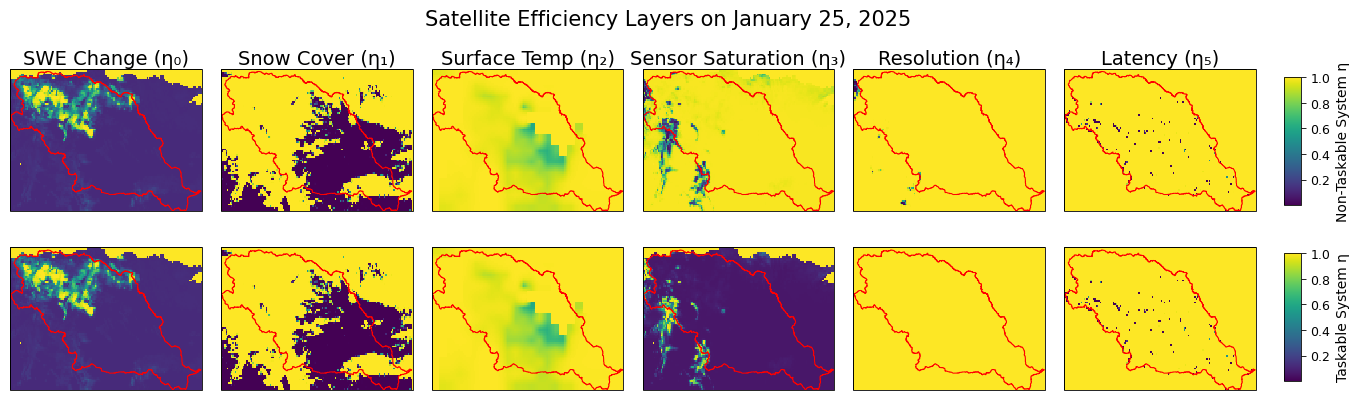

In [27]:
import os
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rioxarray
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs

# ============ CONFIG ============
date = datetime(2025, 1, 25)
date_str_nc = date.strftime("%Y-%m-%d")
date_str_short = date.strftime("%Y%m%d")

satellites = {
    "Non-Taskable System": {
        "file_tag": "GCOM",
        "resolution_file": "efficiency_resolution_20km_masked.nc"
    },
    "Taskable System": {
        "file_tag": "Capella",
        "resolution_file": "efficiency_resolution_SAR_20km_masked.nc"
    }
}

# ============ IO / DATA ============
# Make sure this shapefile path exists (you provided this earlier)
mo_basin = gpd.read_file("WBD_10_HU2_Shape/Shape/WBDHU2.shp").to_crs("EPSG:4326")

# Shared datasets
snowcover_ds = xr.open_dataset("efficiency_snow_cover.nc")
latency_ds = xr.open_dataset(f"recency_outputs/recency_eff_{date_str_short}.nc")
eta5 = latency_ds["recency_efficiency"].squeeze()
eta5.rio.write_crs("EPSG:4326", inplace=True)

# NOTE: cap_tracks and gcom_tracks must exist in the namespace
# If they're files, load them similarly to reward_* earlier.
# Example:
# cap_tracks = gpd.read_file("capella_tracks.geojson")
# gcom_tracks = gpd.read_file("gcom_tracks.geojson")
#
# Here we assume cap_tracks and gcom_tracks already available (as in your earlier notebook).

# ============ FIGURE / EXPORT SETTINGS ============
FIGSIZE = (14, 4)    # width x height (inches)
EXPORT_DPI = 500     # journal-quality
OUT_DIR = "Images"
os.makedirs(OUT_DIR, exist_ok=True)

titles = ["SWE Change (η₀)", "Snow Cover (η₁)", "Surface Temp (η₂)",
          "Sensor Saturation (η₃)", "Resolution (η₄)", "Latency (η₅)"]

# ============ COLLECT LAYERS and global range ============
all_layers = []
vmins, vmaxs = [], []

for sys_label, info in satellites.items():
    file_tag = info["file_tag"]

    swe_path = f"SWE_Change_daily/SWE_Change_{date_str_nc}.nc"
    temp_path = f"daily_airtemp_eta1/temperature_{date_str_short}.nc"
    sensor_path = f"sensor_saturation_daily/Sensor_Saturation_{file_tag}_{date_str_nc}.nc"
    res_path = info["resolution_file"]

    ds_swe = xr.open_dataset(swe_path)
    ds_temp = xr.open_dataset(temp_path)
    ds_sensor = xr.open_dataset(sensor_path)
    res_ds = xr.open_dataset(res_path)

    eta0 = ds_swe["eta0"].squeeze()
    eta1 = snowcover_ds["Weekly_Snow_Cover"].sel(time=date).squeeze()
    eta2 = ds_temp["eta1"].squeeze()
    eta3 = ds_sensor["eta2"].squeeze()
    eta4 = res_ds["Monthly_Resolution_Abs"].sel(time=date).squeeze()

    # ensure CRS metadata for rioxarray operations
    for eta in [eta0, eta1, eta2, eta3, eta4]:
        if not eta.rio.crs:
            eta.rio.write_crs("EPSG:4326", inplace=True)

    layers = [eta0, eta1, eta2, eta3, eta4, eta5]
    all_layers.append((sys_label, layers))

    # compute min/max ignoring all-NaN arrays
    valid_vals = [float(l.min()) for l in layers if not np.isnan(l).all()]
    valid_maxs = [float(l.max()) for l in layers if not np.isnan(l).all()]
    if valid_vals:
        vmins.append(min(valid_vals))
    if valid_maxs:
        vmaxs.append(max(valid_maxs))

    ds_swe.close(); ds_temp.close(); ds_sensor.close(); res_ds.close()

global_vmin = min(vmins) if vmins else 0.0
global_vmax = max(vmaxs) if vmaxs else 1.0

# ============ PLOT GRID ============
fig, axs = plt.subplots(2, 6, figsize=FIGSIZE, subplot_kw={'projection': ccrs.PlateCarree()})

# Reserve space for external colorbars at the right; adjust wspace/hspace explicitly
fig.subplots_adjust(left=0.03, right=0.92, top=0.93, bottom=0.07, wspace=0.10, hspace=0.08)

# consistent map extent for all axes
map_extent = [-114, -90, 37, 50]

for row, (label, layers) in enumerate(all_layers):
    for col, layer in enumerate(layers):
        ax = axs[row, col]

        # handle all-nan layers
        if np.isnan(layer.values).all():
            ax.axis("off")
            continue

        # Use xarray plotting but disable its colorbar and labels
        im = layer.plot(
            ax=ax,
            cmap="viridis",
            vmin=global_vmin, vmax=global_vmax,
            add_colorbar=False,
            add_labels=False,
            transform=ccrs.PlateCarree()
        )

        # uniform sizing
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())
        ax.set_aspect('auto')  # keep uniform cell size across grid

        # clean axes
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel(""); ax.set_ylabel("")

        # basin boundary and small border rectangle
        mo_basin.boundary.plot(ax=ax, color="red", linewidth=0.7, transform=ccrs.PlateCarree())
        rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                         color="black", fill=False, lw=0.6, zorder=6)
        ax.add_patch(rect)

        # layer titles (top row) — fontsize 14
        if row == 0:
            ax.set_title(titles[col], fontsize=14, pad=3)

# ============ EXTERNAL NARROW COLORBARS (one per row) ============
# ScalarMappable to create identical colorbars
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(global_vmin, global_vmax))
sm.set_array([])

# Narrow colorbar parameters (you requested narrow)
cbar_width = 0.012      # narrow bar
cbar_height = 0.32
# place just outside right=0.92 (we used right=0.92 in subplots_adjust)
cbar_x = 0.94
cbar_y_row0 = 0.56
cbar_y_row1 = 0.12

# Row 0 colorbar
cax0 = fig.add_axes([cbar_x, cbar_y_row0, cbar_width, cbar_height])
cb0 = fig.colorbar(sm, cax=cax0, orientation='vertical')
cb0.set_label(f"{all_layers[0][0]} η", fontsize=10)   # cbar label fontsize 12
cb0.ax.tick_params(labelsize=9)

# Row 1 colorbar
cax1 = fig.add_axes([cbar_x, cbar_y_row1, cbar_width, cbar_height])
cb1 = fig.colorbar(sm, cax=cax1, orientation='vertical')
cb1.set_label(f"{all_layers[1][0]} η", fontsize=10)
cb1.ax.tick_params(labelsize=9)

# ============ Figure title and save ============
fig.suptitle(f"Satellite Efficiency Layers on {date.strftime('%B %d, %Y')}",
             fontsize=15, y=1.05)   # main title fontsize 15

# draw canvas (avoid tight_layout because of added axes)
fig.canvas.draw()

# Save PNG (high resolution)
out_png = os.path.join(OUT_DIR, "efficiency_layers.png")
fig.savefig(out_png, dpi=EXPORT_DPI, bbox_inches='tight', pad_inches=0.02)
print("Saved PNG:", out_png)

# Save TIFF (lossless) using Pillow if available
out_tiff = os.path.join(OUT_DIR, "efficiency_layers.tiff")
try:
    from PIL import Image
    with Image.open(out_png) as im:
        im.save(out_tiff, format="TIFF", dpi=(EXPORT_DPI, EXPORT_DPI), compression="tiff_deflate")
    print("Saved TIFF (Pillow):", out_tiff)
except Exception as e:
    # fallback to matplotlib's TIFF save
    fig.savefig(out_tiff, dpi=EXPORT_DPI, bbox_inches='tight', pad_inches=0.02, format='tiff')
    print("Saved TIFF (matplotlib fallback):", out_tiff, "(", e, ")")

plt.show()

# Close opened datasets
snowcover_ds.close()
latency_ds.close()


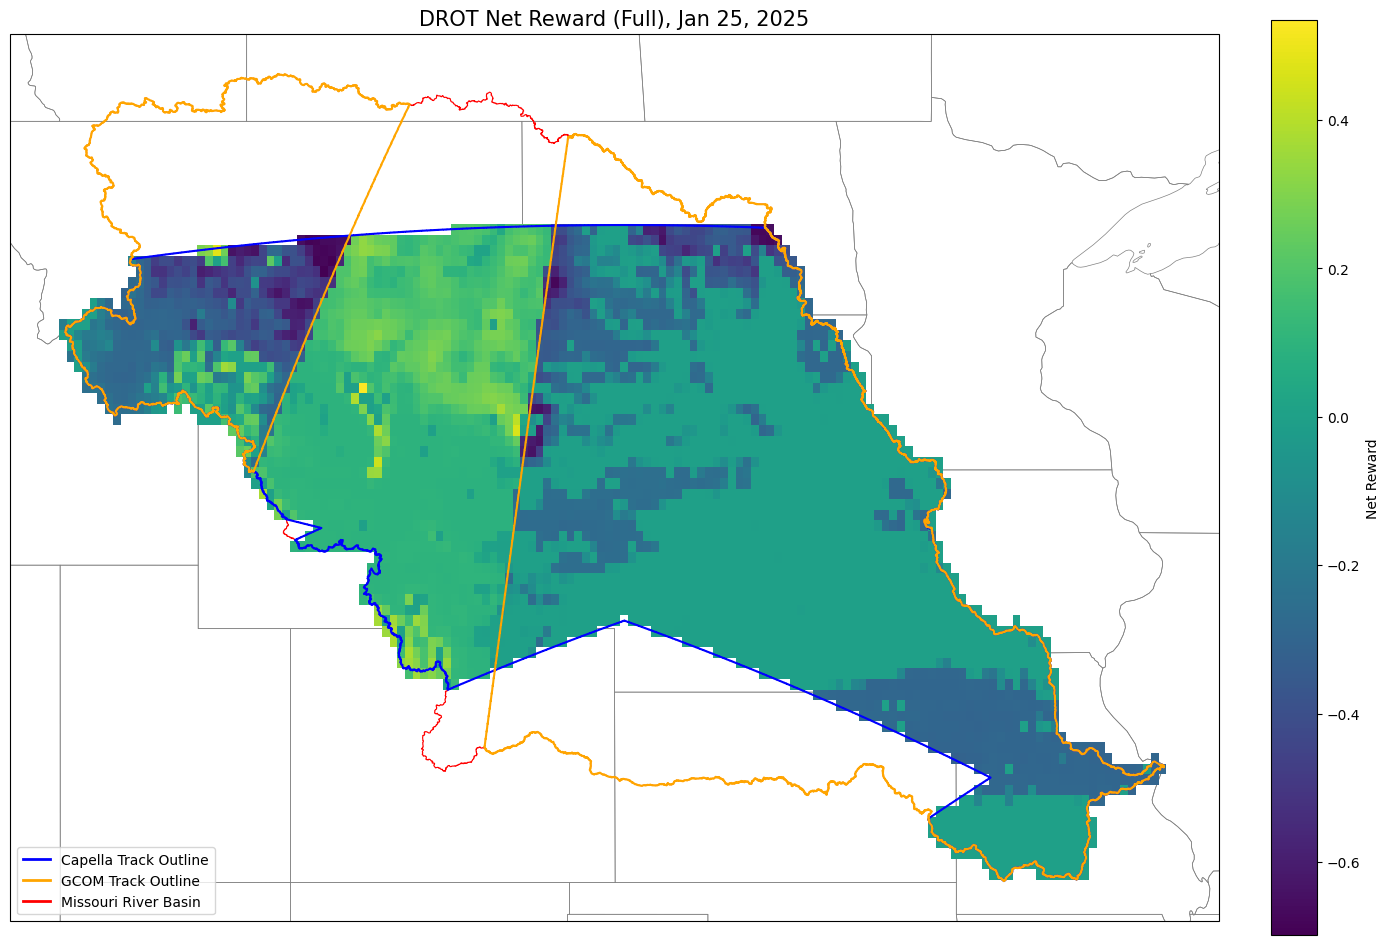

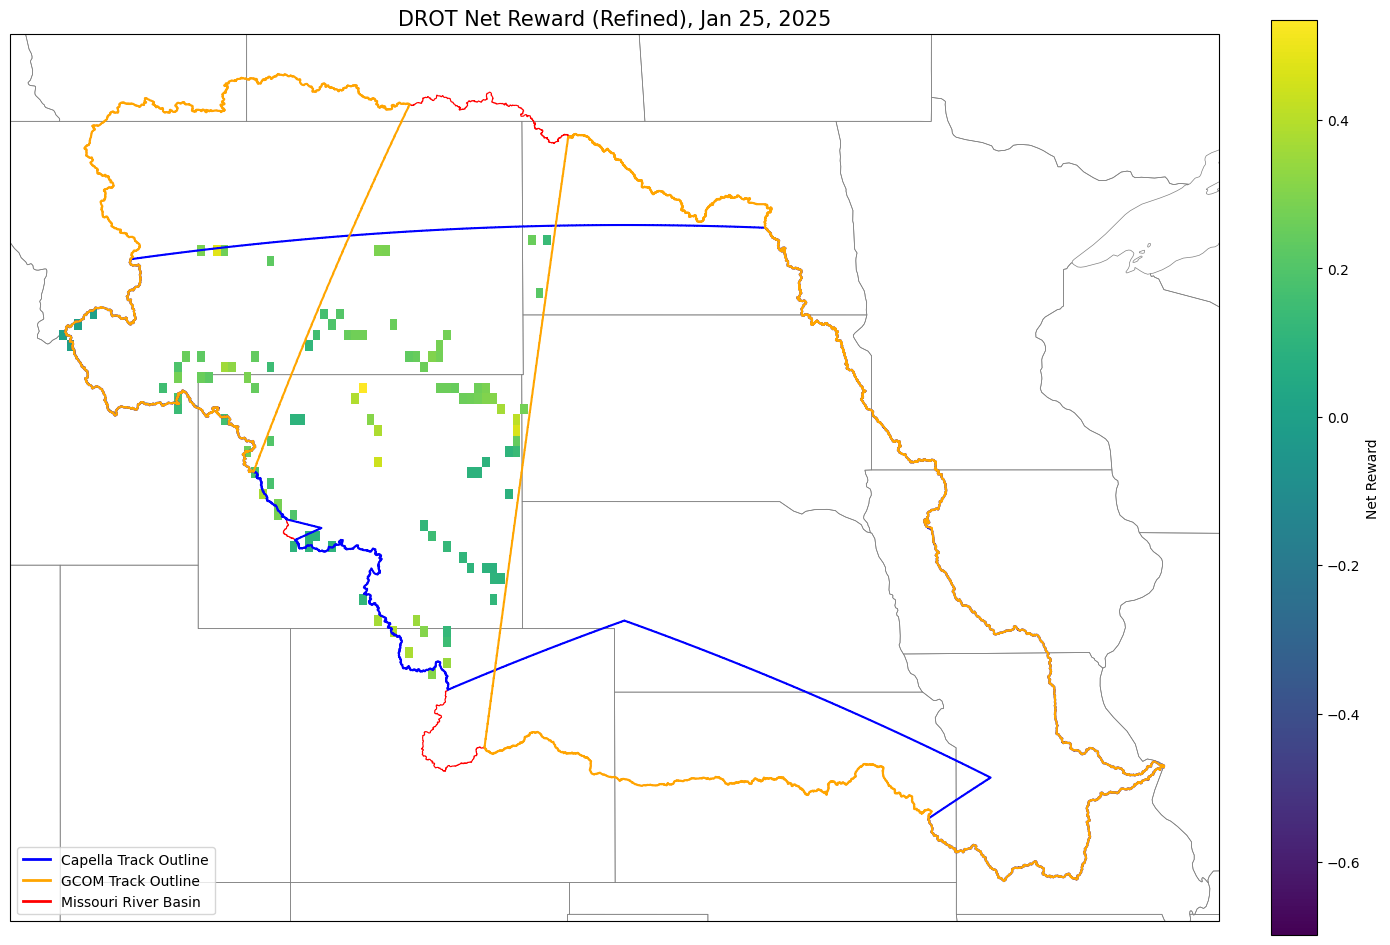

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

# --- Load data ---
reward_full = gpd.read_file("reward_outputs/reward_full_20250125.geojson").to_crs("EPSG:4326")
reward_refined = gpd.read_file("reward_outputs/reward_20250125.geojson").to_crs("EPSG:4326")
mo_basin = gpd.read_file("WBD_10_HU2_Shape/Shape/WBDHU2.shp").to_crs("EPSG:4326")

# --- Capella + GCOM outlines (assumes cap_tracks and gcom_tracks already exist) ---
capella_tracks = gpd.GeoDataFrame(cap_tracks, geometry="geometry").set_crs("EPSG:4326", allow_override=True)
capella_tracks = capella_tracks[~capella_tracks.is_empty & capella_tracks.is_valid]
capella_outline = gpd.overlay(capella_tracks, mo_basin, how="intersection").dissolve()

gcom_tracks = gcom_tracks.set_crs("EPSG:4326", allow_override=True)
gcom_outline = gpd.overlay(gcom_tracks, mo_basin, how="intersection").dissolve()

# --- Shared color scale across both datasets ---
vmin = min(reward_full["final_eta"].min(), reward_refined["final_eta"].min())
vmax = max(reward_full["final_eta"].max(), reward_refined["final_eta"].max())
norm_eta = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# --- Compute bounds ---
bounds = mo_basin.total_bounds
pad_x = (bounds[2] - bounds[0]) * 0.05
pad_y = (bounds[3] - bounds[1]) * 0.05
xlim = (bounds[0] - pad_x, bounds[2] + pad_x)
ylim = (bounds[1] - pad_y, bounds[3] + pad_y)

def plot_reward(gdf, title, cbar_label):
    fig, ax = plt.subplots(figsize=(3.5, 3), subplot_kw={'projection': ccrs.PlateCarree()})

    # Reward heatmap
    gdf.plot(
        ax=ax,
        column="final_eta",
        cmap="viridis",
        edgecolor="none",
        legend=False,
        zorder=2,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax
    )

    # Missouri Basin boundary
    mo_basin.boundary.plot(ax=ax, color="red", linewidth=0.8, zorder=3, transform=ccrs.PlateCarree())

    # Capella + GCOM outlines
    capella_outline.boundary.plot(ax=ax, edgecolor="blue", linewidth=1.5, zorder=4, transform=ccrs.PlateCarree())
    gcom_outline.boundary.plot(ax=ax, color="orange", linewidth=1.5, zorder=5, transform=ccrs.PlateCarree())

    # State borders
    ax.add_feature(cfeature.STATES.with_scale("50m"), edgecolor="gray", linewidth=0.5, zorder=1)

    # Extent and ticks
    ax.set_extent([*xlim, *ylim], crs=ccrs.PlateCarree())
    # xticks = list(range(int(xlim[0]), int(xlim[1]) + 1, 5))
    # yticks = list(range(int(ylim[0]), int(ylim[1]) + 1, 2))
    # ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    # ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.0f"))

    # Colorbar
    sm_eta = mpl.cm.ScalarMappable(norm=norm_eta, cmap="viridis")
    sm_eta.set_array([])
    cbar = fig.colorbar(sm_eta, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label(cbar_label)

    # Legend
    legend_elements = [
        Line2D([0], [0], color="blue", lw=2, label="Capella Track Outline"),
        Line2D([0], [0], color="orange", lw=2, label="GCOM Track Outline"),
        Line2D([0], [0], color="red", lw=2, label="Missouri River Basin"),
    ]
    ax.legend(handles=legend_elements, loc="lower left", fontsize="medium", frameon=True)

    ax.set_title(title, fontsize=15)
    # ax.set_xlabel("Longitude")
    # ax.set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()

# --- Plot each separately with same scale ---
plot_reward(reward_full, "DROT Net Reward (Full), Jan 25, 2025", "Net Reward")
plot_reward(reward_refined, "DROT Net Reward (Refined), Jan 25, 2025", "Net Reward")


Saved PNG: Images/reward_comparison_panel.png
Saved TIFF (Pillow): Images/reward_comparison_panel.tiff


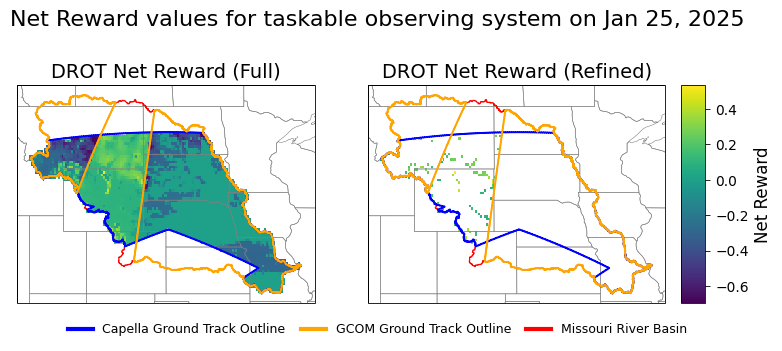

In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D



export_dpi = 500

fig_width_in = 8.0   # 8 in * 500 dpi = 4000 px (> 3740)
fig_height_in = 4.5  # adjust for aspect

# Fonts / sizes
suptitle_fontsize = 16
subplot_title_fontsize = 14
cbar_label_fontsize = 12
legend_fontsize = 9
map_facecolor = "white"

mpl.rcParams.update({
    "font.size": 10,
    "axes.titlesize": subplot_title_fontsize,
    "figure.titlesize": suptitle_fontsize,
    "legend.fontsize": legend_fontsize,
})


# Load data 

reward_full = gpd.read_file("reward_outputs/reward_full_20250125.geojson").to_crs("EPSG:4326")
reward_refined = gpd.read_file("reward_outputs/reward_20250125.geojson").to_crs("EPSG:4326")
mo_basin = gpd.read_file("WBD_10_HU2_Shape/Shape/WBDHU2.shp").to_crs("EPSG:4326")


capella_tracks = gpd.GeoDataFrame(cap_tracks, geometry="geometry").set_crs("EPSG:4326", allow_override=True)
capella_tracks = capella_tracks[~capella_tracks.is_empty & capella_tracks.is_valid]
capella_outline = gpd.overlay(capella_tracks, mo_basin, how="intersection").dissolve()

gcom_tracks = gcom_tracks.set_crs("EPSG:4326", allow_override=True)
gcom_outline = gpd.overlay(gcom_tracks, mo_basin, how="intersection").dissolve()


# Shared color scale
vmin = min(reward_full["final_eta"].min(), reward_refined["final_eta"].min())
vmax = max(reward_full["final_eta"].max(), reward_refined["final_eta"].max())
norm_eta = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_name = "viridis"


# Compute bounds and padding for the map extent
bounds = mo_basin.total_bounds  # (minx, miny, maxx, maxy)
pad_x = (bounds[2] - bounds[0]) * 0.05
pad_y = (bounds[3] - bounds[1]) * 0.05
xlim = (bounds[0] - pad_x, bounds[2] + pad_x)
ylim = (bounds[1] - pad_y, bounds[3] + pad_y)


# Build figure: two side-by-side maps + external colorbar + legend below
fig = plt.figure(figsize=(fig_width_in, fig_height_in), facecolor=map_facecolor)

# Left axes (Panel A)
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
# Right axes (Panel B)
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

# List for plotting order
panels = [
    (ax1, reward_full, "DROT Net Reward (Full)"),
    (ax2, reward_refined, "DROT Net Reward (Refined)"),
]

# Plot each panel (GeoDataFrame .plot uses shapely patches)
for ax, gdf, title in panels:

    ax.set_facecolor(map_facecolor)

    gdf.plot(
        ax=ax,
        column="final_eta",
        cmap=cmap_name,
        edgecolor="none",
        linewidth=0,
        zorder=2,
        transform=ccrs.PlateCarree(),
        norm=norm_eta
    )

    # basin boundary and outlines
    mo_basin.boundary.plot(ax=ax, color="red", linewidth=0.8, zorder=4, transform=ccrs.PlateCarree())
    capella_outline.boundary.plot(ax=ax, edgecolor="blue", linewidth=1.4, zorder=5, transform=ccrs.PlateCarree())
    gcom_outline.boundary.plot(ax=ax, color="orange", linewidth=1.4, zorder=6, transform=ccrs.PlateCarree())

    # light state borders
    ax.add_feature(cfeature.STATES.with_scale("50m"), edgecolor="gray", linewidth=0.4, zorder=3)

    # extent and remove ticks/labels for cleaner map
    ax.set_extent([*xlim, *ylim], crs=ccrs.PlateCarree())
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title, fontsize=subplot_title_fontsize, pad=6)

    # Add a thin black border around the map (axes fraction coords)
    from matplotlib.patches import Rectangle
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, color="black", fill=False, lw=0.7, zorder=20)
    ax.add_patch(rect)


left = 0.05
right = 0.86   
top = 1.0 #0.92
bottom = 0.14
fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom, wspace=0.18)


pos = ax1.get_position()  # [x0, y0, x1, y1] in figure coordinates


cbar_left = 0.88        
cbar_bottom = pos.y0    
cbar_width = 0.03
cbar_height = pos.height 

cax = fig.add_axes([cbar_left, cbar_bottom, cbar_width, cbar_height])



# Colorbar axes 
# cax = fig.add_axes([0.88, 0.14, 0.03, 0.75])  # [left, bottom, width, height]
sm = mpl.cm.ScalarMappable(norm=norm_eta, cmap=cmap_name)
sm.set_array([])  # required for colorbar
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_label("Net Reward", fontsize=cbar_label_fontsize)
cbar.ax.tick_params(labelsize=10)


# Shared legend below as a horizontal line
legend_handles = [
    Line2D([0], [0], color="blue", lw=3, label="Capella Ground Track Outline"),
    Line2D([0], [0], color="orange", lw=3, label="GCOM Ground Track Outline"),
    Line2D([0], [0], color="red", lw=3, label="Missouri River Basin"),
]

# place legend centered under the two axes
# Shared legend below as a horizontal line
fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.23),  # was 0.05 -> moves it upward
    ncol=3,
    frameon=False,               # removes the box around legend
    fontsize=legend_fontsize,
    handlelength=2.0,
    columnspacing=1.2,
)


fig.suptitle("Net Reward values for taskable observing system on Jan 25, 2025",
             fontsize=suptitle_fontsize, y=0.98)

fig.canvas.draw()


# Save outputs
png_out = "Images/reward_comparison_panel.png"
tiff_out = "Images/reward_comparison_panel.tiff"

fig.savefig(png_out, dpi=export_dpi, bbox_inches="tight", facecolor=fig.get_facecolor())
print("Saved PNG:", png_out)

# Try Pillow TIFF conversion for lossless compression and exact pixel match
try:
    from PIL import Image
    with Image.open(png_out) as im:
        im.save(tiff_out, format="TIFF", dpi=(export_dpi, export_dpi), compression="tiff_deflate")
    print("Saved TIFF (Pillow):", tiff_out)
except Exception as e:
    fig.savefig(tiff_out, dpi=export_dpi, bbox_inches="tight", facecolor=fig.get_facecolor(), format="tiff")
    print("Saved TIFF (matplotlib fallback):", tiff_out, "(fallback reason: {})".format(e))

plt.show()
plt.close(fig)
